In [1]:
import pandas as pd
import pandas_datareader.data as web
import numpy as np

import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

np.random.seed(1)


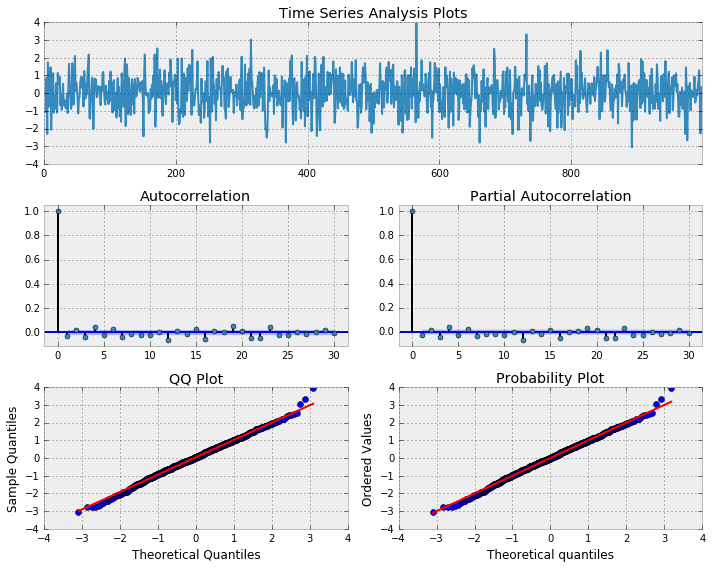

In [2]:
def tsplot(y, lags=None, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
        
# plot of discrete white noise
randser = np.random.normal(size=1000)
tsplot(randser, lags=30)

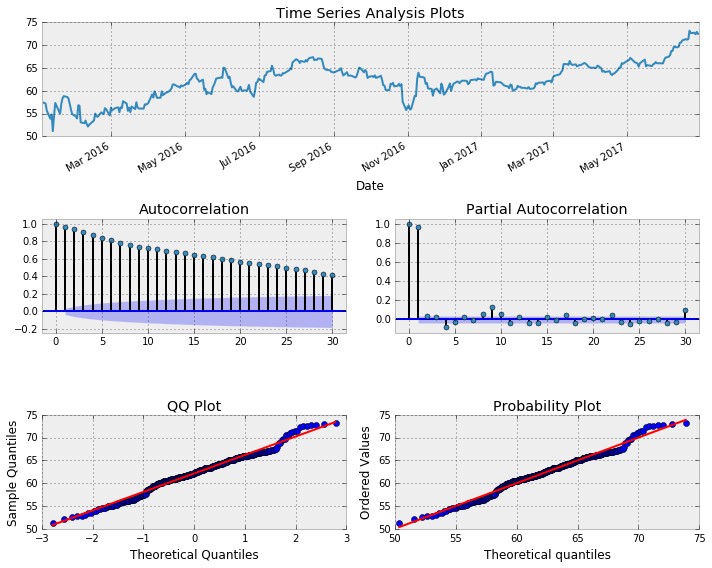

In [3]:
df= web.DataReader('ABBV', 'google', start='2016-01-01', end='2017-07-01')
tsplot(df['Close'], lags=30)

/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/base/model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: overflow encountered in exp
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:628: RuntimeWarning: invalid value encountered in divide
  newparams = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python2.7/site-packages/statsmodels/tsa/tsatools.py:629: RuntimeWarning: overflow encountered in exp
  tmp = ((1-np.exp(-params))/(1+np.exp(-params))).copy()
/usr/local/lib/python2.7/site-packages/statsmodels/tsa/

aic: 868.52766 | order: (4, 1, 1)
                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                  326
Model:                 ARIMA(4, 1, 1)   Log Likelihood                -428.264
Method:                           mle   S.D. of innovations              0.900
Date:                Tue, 01 Aug 2017   AIC                            868.528
Time:                        23:32:46   BIC                            891.249
Sample:                    01-05-2016   HQIC                           877.595
                         - 04-20-2017                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
ar.L1.D.Close     0.7659      0.088      8.657      0.000       0.592       0.939
ar.L2.D.Close    -0.0249      0.069     -0.362      0.717      -0.159       0.110
ar.L3.

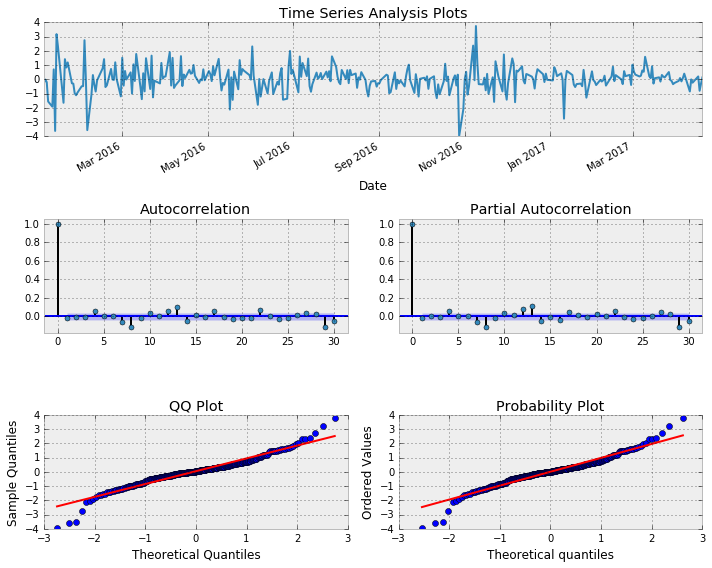

In [4]:
best_aic = np.inf 
best_order = None
best_mdl = None

for i in xrange(5):
    for d in xrange(2):
        for j in xrange(5):
            try:
                tmp_mdl = smt.ARIMA(df['Close'][:-50], order=(i,d,j)).fit(method='mle', trend='nc')
                tmp_aic = tmp_mdl.aic
                if tmp_aic < best_aic:
                    best_aic = tmp_aic
                    best_order = (i, d, j)
                    best_mdl = tmp_mdl
            except: continue

print('aic: {:6.5f} | order: {}'.format(best_aic, best_order))
tsplot(best_mdl.resid, lags=30)
print(best_mdl.summary())

In [12]:

idx = pd.date_range(df.index[-50], df.index[-1], freq='D')
n_steps = idx.shape[0]

f, err95, ci95 = best_mdl.forecast(steps=n_steps) # 95% CI
_, err99, ci99 = best_mdl.forecast(steps=n_steps, alpha=0.01) # 99% CI

fc_95 = pd.DataFrame(np.column_stack([f, ci95]), index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([ci99]), index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all.head()

,forecast,lower_ci_95,lower_ci_99,upper_ci_95,upper_ci_99
2017-04-21,63.774051,62.010500,61.456352,65.537603,66.091751
2017-04-22,63.843808,61.457089,60.707128,66.230527,66.980489
2017-04-23,63.988322,61.198083,60.321326,66.778562,67.655319
2017-04-24,64.038118,60.810603,59.796444,67.265634,68.279793
2017-04-25,64.085482,60.557504,59.448933,67.613460,68.722031
2017-04-26,64.132621,60.383373,59.205274,67.881869,69.059968
2017-04-27,64.150488,60.209864,58.971630,68.091112,69.329346
2017-04-28,64.162220,60.068314,58.781915,68.256127,69.542525
2017-04-29,64.170373,59.946316,58.619021,68.394430,69.721725
2017-04-30,64.171036,59.828370,58.463806,68.513701,69.878266


In [11]:
dftest=df.r['Close']
print dftest
df['Forecast'] = best_mdl.predict(dynamic=True)
df[['Close', 'Forecast']].plot()

AttributeError: 'DataFrame' object has no attribute 'r'